In [2]:
import polars as pl
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


from tqdm import tqdm

import polars.selectors as cs
import wandb

from atma_16.dataset.dataset import AtmaData16Loader

In [3]:
exp_name = "902_check_oof"
input_dir = Path("../input")
output_dir = Path("../output") / exp_name
output_dir.mkdir(parents=True, exist_ok=True)

In [4]:
oof_path = Path("../output/013_add_bpr_and_del_many_cand") / "oof_0.403530511424644.parquet"
oof_df = pl.read_parquet(oof_path)

In [5]:
dl = AtmaData16Loader(input_dir=input_dir)

train = dl.load_train_log()
label = dl.load_train_label()
yado = dl.load_yado()

In [6]:
col = "sml_cd"
last_log = train.group_by("session_id").tail(1)
max_seq_no = train.group_by("session_id").agg((pl.lit(1) + pl.col("seq_no").max()).alias("max_seq_no"))

df = (
    last_log.join(label, on="session_id")
    .join(yado, on="yad_no")
    .join(yado, left_on="yad_no_right", right_on="yad_no", how="left")
    .join(max_seq_no, on="session_id")
    .select(["session_id", "yad_no", "yad_no_right", col, f"{col}_right", "max_seq_no"])
    .rename(
        {
            "yad_no": "last_yad_no",
            "yad_no_right": "label_yad_no",
            f"{col}_right": f"label_{col}",
            f"{col}": f"last_{col}",
        }
    )
)
df

session_id,last_yad_no,label_yad_no,last_sml_cd,label_sml_cd,max_seq_no
i64,i64,i64,i64,i64,i64
196760,3498,11366,104,104,1
240407,6113,8150,125,125,2
204358,2214,5179,88,88,1
141174,11332,7833,288,288,1
21901,13794,4579,88,88,1
83894,13724,511,151,151,1
244212,11801,12767,125,186,1
264389,7668,4004,87,228,1
97920,4429,1146,408,408,2


In [73]:
len(oof_df[["session_id", "yad_no"]].unique()) / len(oof_df)

0.9982208801320598

<Axes: ylabel='Frequency'>

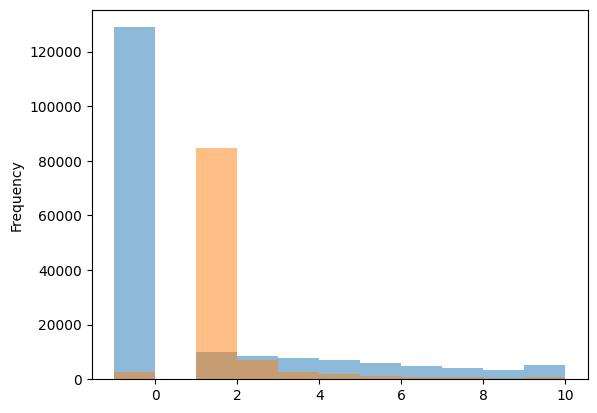

In [81]:
oof_df = oof_df.unique(subset=["session_id", "yad_no"])

ses_pred_df = (
    oof_df["session_id"]
    .unique()
    .to_frame()
    .join(oof_df.filter(pl.col("label") == 1), how="left", on="session_id")
    .fill_null(-1)
    .join(max_seq_no, on="session_id")
    .sort("session_id")
)

# sns.boxplot(ses_pred_df.to_pandas(), x="max_seq_no", y="rank")
ses_pred_df.filter(pl.col("max_seq_no") == 1).to_pandas()["rank"].plot.hist(bins=11, alpha=0.5)

ses_pred_df.filter(pl.col("max_seq_no") > 1).to_pandas()["rank"].plot.hist(bins=11, alpha=0.5)

In [85]:
pl.Config.set_tbl_rows(100)
pl.Config.set_fmt_table_cell_list_len(10)

pred_list_df = (
    oof_df.join(yado.select(["yad_no", col]), on="yad_no", how="left")
    .join(df, on="session_id", how="left")
    .group_by("session_id", "max_seq_no")
    .agg(["label", col, f"last_{col}", f"label_{col}"])
    .with_columns(pl.col(f"last_{col}").list.get(0), pl.col(f"label_{col}").list.get(0))
    .sort("session_id")
)

In [7]:
oof_df.join(yado.select(["yad_no", col]), on="yad_no", how="left").join(df, on="session_id", how="left")

session_id,yad_no,label,score,rank,sml_cd,last_yad_no,label_yad_no,last_sml_cd,label_sml_cd,max_seq_no
i64,i64,i32,f32,u32,i64,i64,i64,i64,i64,i64
0,11882,0,0.167535,1,293,2395,4101,293,293,1
0,2808,0,0.128543,2,293,2395,4101,293,293,1
0,5821,0,0.07864,3,293,2395,4101,293,293,1
0,5289,0,0.076182,4,293,2395,4101,293,293,1
0,4101,1,0.06664,5,293,2395,4101,293,293,1
0,12837,0,0.05621,6,293,2395,4101,293,293,1
0,7281,0,0.03808,7,293,2395,4101,293,293,1
0,3324,0,0.02744,8,293,2395,4101,293,293,1
0,1648,0,0.022576,9,293,2395,4101,293,293,1


In [137]:
yado["sml_cd"].is_null().sum()

0

In [140]:
oof_df["yad_no"].is_null().sum()

1638

In [138]:
max_len1_df.filter((pl.col("sml_cd") == pl.col("label_sml_cd")).is_null())

session_id,yad_no,label,score,rank,sml_cd,last_yad_no,label_yad_no,last_sml_cd,label_sml_cd,max_seq_no
i64,i64,i32,f32,u32,i64,i64,i64,i64,i64,i64
109985,null,0,1.1288e-10,10,null,13708,2383,24,24,1
222497,null,0,1.0628e-10,10,null,6242,2816,210,210,1
173993,null,0,2.8169e-9,10,null,1614,7517,19,19,1
281251,null,0,1.5611e-9,10,null,1215,9678,419,419,1
263740,null,0,2.5193e-10,10,null,4421,11099,485,485,1
282615,null,0,5.5389e-8,10,null,11078,2653,143,143,1
206738,null,0,4.4010e-8,10,null,1039,2588,88,88,1
238791,null,0,3.7551e-9,10,null,9587,13027,263,263,1
112972,null,0,4.1386e-9,10,null,730,10865,302,302,1


In [8]:
max_len1_df = (
    oof_df.join(yado.select(["yad_no", col]), on="yad_no", how="left")
    .join(df, on="session_id", how="left")
    .filter(pl.col("max_seq_no") == 1)
)
ratio_df = (
    max_len1_df.with_columns(
        pl.col("label").max().over("session_id").alias("ses_label"),
        (pl.col("sml_cd") == pl.col("label_sml_cd")).alias("same_label_cd"),
        (pl.col("sml_cd") == pl.col("last_sml_cd")).alias("same_last_cd"),
        (pl.col("label_sml_cd") == pl.col("last_sml_cd")).alias("same_label_last_cd"),
    )
    .group_by(pl.col("same_label_last_cd"), pl.col("same_label_cd"), pl.col("same_last_cd"))
    .agg((pl.count("score") / len(max_len1_df)), pl.col("ses_label").mean())
    .sort(pl.col("*"))
)
ratio_df.filter(pl.col("same_label_cd").is_not_null())

same_label_last_cd,same_label_cd,same_last_cd,score,ses_label
bool,bool,bool,f64,f64
false,false,false,0.025622,0.136782
false,false,true,0.183249,0.123361
false,true,false,0.033677,0.332757
true,false,false,0.058301,0.477262
true,true,true,0.699152,0.470452


<Axes: ylabel='Frequency'>

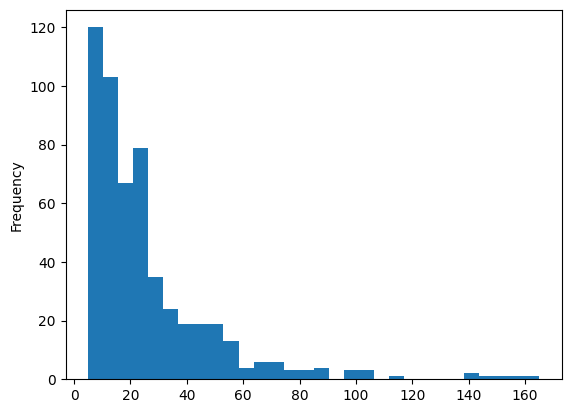

In [145]:
yado.group_by("sml_cd").agg(pl.count("yad_no")).to_pandas()["yad_no"].plot.hist(bins=30)

In [130]:
session_label_df = (
    oof_df.join(yado.select(["yad_no", col]), on="yad_no", how="left")
    .join(df, on="session_id", how="left")
    .group_by("session_id")
    .agg(
        [
            (pl.col("label") == 1).max().alias("is_match"),
            (pl.col("last_sml_cd") == pl.col("sml_cd")).sum().alias("same_pred_last"),
            (pl.col("label_sml_cd") == pl.col("sml_cd")).sum().alias("same_pred_label"),
            (pl.col("last_sml_cd") == pl.col("label_sml_cd")).max().alias("samle_last_label"),
        ]
    )
)
session_label_df

session_id,is_match,same_pred_last,same_pred_label,samle_last_label
i64,bool,u32,u32,bool
185747,true,9,9,true
257967,false,10,10,true
93204,false,9,0,false
233717,true,9,9,true
206195,false,10,10,true
149049,false,9,9,true
267804,false,9,0,false
186795,true,8,8,true
34611,true,10,10,true


<Axes: xlabel='rank', ylabel='Count'>

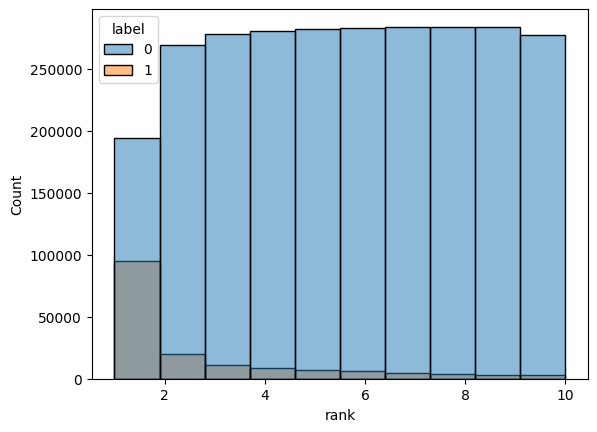

In [4]:
sns.histplot(data=oof_df.to_pandas(), hue="label", x="rank", bins=10)

<Axes: xlabel='score', ylabel='Count'>

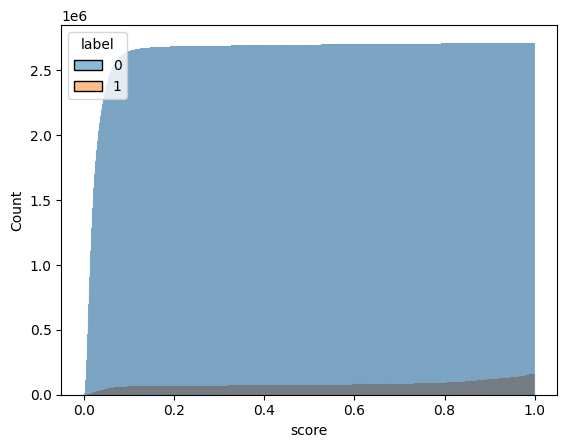

In [5]:
sns.histplot(data=oof_df.to_pandas(), hue="label", x="score", cumulative=True)

In [6]:
oof_df

session_id,yad_no,label,score,rank
i64,i64,i32,f32,u32
0,997,0,0.07266,1
0,5821,0,0.068153,2
0,7157,0,0.06211,3
0,12837,0,0.043272,4
0,1648,0,0.042363,5
0,12846,0,0.0397,6
0,11101,0,0.036732,7
0,11134,0,0.032552,8
0,4391,0,0.026875,9
